In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


### GloVe+LSTM모델

In [ ]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:  #변환 오류가 발생하면 해당 라인은 건너뜀
                continue
    return embeddings_index

#GloVe 임베딩 파일 경로
glove_file = 'glove.6B.100d.txt'
#GloVe 임베딩 로드
embeddings_index = load_glove_embeddings(glove_file)

#전처리 함수
def preprocess_text(text):
    #URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #사용자 언급(@)과 해시태그(#) 제거
    text = re.sub(r'\@\w+|\#', '', text)
    #특수 문자 및 숫자 제거
    text = re.sub(r'[^A-Za-z\s]', '', text)
    #소문자로 변환
    return text.lower().strip()

data = pd.read_csv("tweet_emotions.csv")
#data['sentiment'].unique()

data['clean_text'] = data['content'].apply(preprocess_text)

#긍정적 감정을 정의
positive_sentiments = ['enthusiasm', 'love', 'happiness', 'fun', 'relief']

#'sentiment' 값을 이진 값으로 변환
data['feel'] = data['sentiment'].apply(lambda x: 1 if x in positive_sentiments else 0)

#긴급 단어 목록
emergency_keywords = ['help', 'danger', 'urgent', 'scared', 'assistance']

#긴급 점수 추가
data['emergency_score'] = data['clean_text'].apply(
    lambda x: sum(word in x for word in emergency_keywords)
)

In [ ]:
#학습, 검증 데이터 분리
X = data[['clean_text', 'emergency_score']]
y = data['feel']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Tokenizer 생성
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['clean_text'])

#텍스트를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(X_val['clean_text'])

#패딩
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

from sklearn.utils.class_weight import compute_class_weight

#긴급 점수 추가(Feature Engineering)
X_train_features = np.hstack((X_train_padded, np.array(X_train['emergency_score']).reshape(-1, 1)))
X_val_features = np.hstack((X_val_padded, np.array(X_val['emergency_score']).reshape(-1, 1)))

#SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

#GloVe 임베딩 행렬 생성
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
#모델 설계
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(zip(np.unique(y_train_resampled), class_weights))

#모델 학습
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_features, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

#결과 확인
print("모델 학습 완료!")
print(history.history)  # history 객체 출력

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6211 - loss: 0.6383 - val_accuracy: 0.7218 - val_loss: 0.5624
Epoch 2/10
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7372 - loss: 0.5337 - val_accuracy: 0.6746 - val_loss: 0.6260
Epoch 3/10
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7608 - loss: 0.4895 - val_accuracy: 0.7119 - val_loss: 0.5871
Epoch 4/10
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7792 - loss: 0.4578 - val_accuracy: 0.7011 - val_loss: 0.6235
모델 학습 완료!
{'accuracy': [0.6725941300392151, 0.7418177723884583, 0.7642724514007568, 0.7793352007865906], 'loss': [0.6003031730651855, 0.5247331857681274, 0.48634350299835205, 0.45886361598968506], 'val_accuracy': [0.721750020980835, 0.6746249794960022, 0.7118750214576721, 0.7011250257492065], 'val_loss': [0.5624038577079773, 0.6260023713111877, 0.5871214270591736, 0.6234976053237915]}


In [ ]:
from sklearn.metrics import classification_report

#검증 데이터에 대한 예측
y_pred = model.predict(X_val_padded)
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      5378
           1       0.54      0.64      0.58      2622

    accuracy                           0.70      8000
   macro avg       0.67      0.68      0.68      8000
weighted avg       0.72      0.70      0.71      8000



In [ ]:
#긴급도 예측 테스트
test_sentences = [
    "I am very scared right now",  #긴급
    "It's a beautiful day!",  #일반
    "Help me! I'm in danger.",  #긴급
    "Everything is fine.",  #일반
    "I need urgent assistance now!"  #긴급
]

#텍스트 전처리 적용 (자신의 전처리 함수 사용)
test_sentences_processed = [preprocess_text(sentence) for sentence in test_sentences]

#텍스트를 시퀀스로 변환
test_sequences = tokenizer.texts_to_sequences(test_sentences_processed)

#패딩 (훈련 데이터와 동일한 max_len 사용)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

#예측
predictions = model.predict(test_padded)

#결과 출력
for i, sentence in enumerate(test_sentences):
    urgency = "긴급" if predictions[i][0] < 0.5 else "일반"
    print(f"텍스트: {sentence} => 예측된 긴급도: {urgency}")  #점수: {predictions[i][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
텍스트: I am very scared right now => 예측된 긴급도: 긴급 점수: 0.31)
텍스트: It's a beautiful day! => 예측된 긴급도: 일반 점수: 0.78)
텍스트: Help me! I'm in danger. => 예측된 긴급도: 일반 점수: 0.80)
텍스트: Everything is fine. => 예측된 긴급도: 긴급 점수: 0.42)
텍스트: I need urgent assistance now! => 예측된 긴급도: 긴급 점수: 0.33)


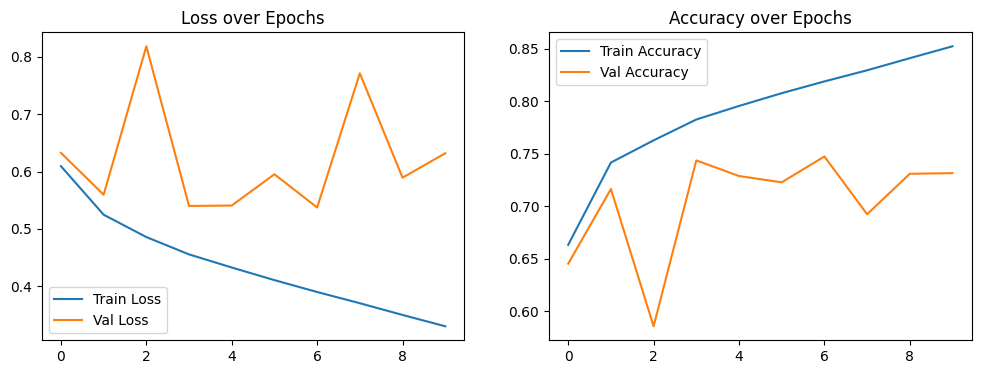

In [ ]:
#손실 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

#정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
#손실 값 출력
print("Train Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])

#정확도 값 출력
print("Train Accuracy:", history.history['accuracy'])
print("Validation Accuracy:", history.history['val_accuracy'])

Train Loss: [0.6093568801879883, 0.524756908416748, 0.48583152890205383, 0.4556402862071991, 0.43280288577079773, 0.41081690788269043, 0.39012759923934937, 0.37057894468307495, 0.3501679599285126, 0.3304181396961212]
Validation Loss: [0.6325651407241821, 0.5595179796218872, 0.8182035088539124, 0.5399923920631409, 0.5407429933547974, 0.5952668786048889, 0.5374016761779785, 0.7711144685745239, 0.5893275141716003, 0.6317974925041199]
Train Accuracy: [0.6633426547050476, 0.7417015433311462, 0.7628544569015503, 0.7827057242393494, 0.7956066727638245, 0.8077870607376099, 0.8189911842346191, 0.829590916633606, 0.8411204218864441, 0.852463960647583]
Validation Accuracy: [0.6453750133514404, 0.7164999842643738, 0.5857499837875366, 0.7437499761581421, 0.7288749814033508, 0.7228749990463257, 0.7475000023841858, 0.6924999952316284, 0.7310000061988831, 0.7316250205039978]


### BERT모델


In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

#데이터 로드 및 전처리
def preprocess_text(text):
    #URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #사용자 언급(@)과 해시태그(#) 제거
    text = re.sub(r'\@\w+|\#', '', text)
    #특수 문자 및 숫자 제거
    text = re.sub(r'[^A-Za-z\s]', '', text)
    #소문자로 변환
    return text.lower().strip()

data = pd.read_csv("tweet_emotions.csv")
data['clean_text'] = data['content'].apply(preprocess_text)

#긍정적 감정을 정의
positive_sentiments = ['enthusiasm', 'love', 'happiness', 'fun', 'relief']

#'sentiment' 값을 이진 값으로 변환
data['feel'] = data['sentiment'].apply(lambda x: 1 if x in positive_sentiments else 0)

In [ ]:
#학습, 검증 데이터 분리
X = data['clean_text']
y = data['feel']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Tokenizer를 이용한 텍스트 전처리
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, tokenizer, max_len=50):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)

#입력 데이터 준비
train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
val_input_ids = val_encodings['input_ids']
val_attention_mask = val_encodings['attention_mask']

#모델 구축
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model_name="bert-base-uncased", **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(bert_model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state[:, 0, :]  # [CLS] 토큰 출력

#입력 정의
input_ids = tf.keras.Input(shape=(50,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(50,), dtype=tf.int32, name="attention_mask")

#BERT 레이어 추가
bert_output = BertLayer()([input_ids, attention_mask])

#이후 레이어
x = tf.keras.layers.Dropout(0.3)(bert_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#모델 생성
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
#모델 학습
history = model.fit(
    [train_input_ids, train_attention_mask], y_train,
    validation_data=([val_input_ids, val_attention_mask], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 127s 114ms/step - accuracy: 0.7149 - loss: 0.5611 - val_accuracy: 0.7406 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 126s 104ms/step - accuracy: 0.7423 - loss: 0.5222 - val_accuracy: 0.7399 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 104ms/step - accuracy: 0.7449 - loss: 0.5159 - val_accuracy: 0.7454 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 144s 106ms/step - accuracy: 0.7467 - loss: 0.5129 - val_accuracy: 0.7486 - val_loss: 0.5128 - learning_rate: 0.0010
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 105ms/step - accuracy: 0.7486 - loss: 0.5150 - val_accuracy: 0.7452 - val_loss: 0.5138 - learning_rate: 0.0010
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 104ms/step - accuracy: 0.7509 - loss: 0.5084 - val_accuracy: 0.7448 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 104ms

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#검증 데이터 전처리
val_encodings = tokenize_data(X_val, tokenizer)

#검증 데이터에 대한 예측
y_pred = model.predict([val_encodings['input_ids'], val_encodings['attention_mask']])

#y_pred는 0.5 이상이면 "일반"으로 예측되고, 0.5 미만이면 "긴급"으로 예측
y_pred_class = (y_pred > 0.5).astype(int)

# classification_report 출력
print(classification_report(y_val, y_pred_class))

250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      5378
           1       0.67      0.45      0.54      2622

    accuracy                           0.75      8000
   macro avg       0.72      0.67      0.68      8000
weighted avg       0.74      0.75      0.73      8000



In [ ]:
#긴급도 예측 테스트
test_sentences = [
    "I am very scared right now",  # 긴급
    "It's a beautiful day!",  # 일반
    "Help me! I'm in danger.",  # 긴급
    "Everything is fine.",  #일반
    "I need urgent assistance now!"  #긴급
]

#텍스트 전처리 적용
test_sentences_processed = [preprocess_text(sentence) for sentence in test_sentences]

#BERT 입력 형식으로 변환
test_encodings = tokenize_data(test_sentences_processed, tokenizer)

#예측
predictions = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

#결과 출력
for i, sentence in enumerate(test_sentences):
    urgency = "긴급" if predictions[i][0] < 0.5 else "일반"
    print(f"텍스트: {sentence} => 예측된 긴급도: {urgency}") #(점수: {predictions[i][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
텍스트: I am very scared right now => 예측된 긴급도: 긴급 (점수: 0.03)
텍스트: It's a beautiful day! => 예측된 긴급도: 일반 (점수: 0.81)
텍스트: Help me! I'm in danger. => 예측된 긴급도: 긴급 (점수: 0.11)
텍스트: Everything is fine. => 예측된 긴급도: 긴급 (점수: 0.30)
텍스트: I need urgent assistance now! => 예측된 긴급도: 긴급 (점수: 0.05)


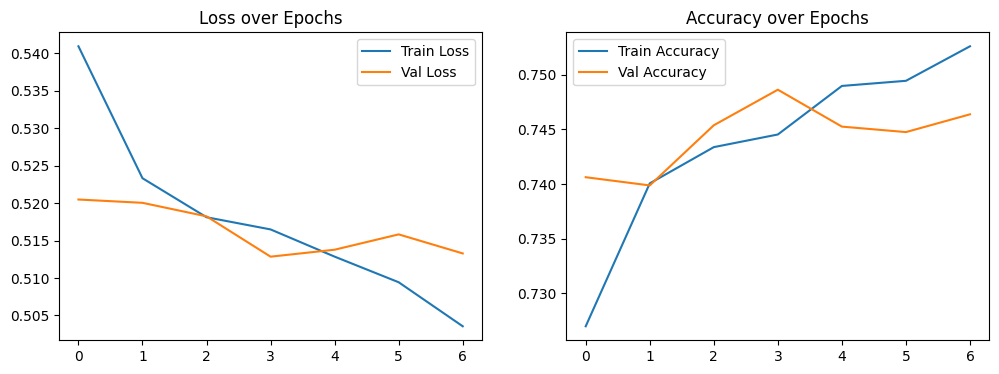

In [ ]:
#손실 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

#정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
#손실 값 출력
print("Train Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])

#정확도 값 출력
print("Train Accuracy:", history.history['accuracy'])
print("Validation Accuracy:", history.history['val_accuracy'])

Train Loss: [0.5409368276596069, 0.5233176946640015, 0.5181099772453308, 0.5164819955825806, 0.5128483772277832, 0.5094270706176758, 0.5035498738288879]
Validation Loss: [0.5204761028289795, 0.5200344324111938, 0.518227756023407, 0.5128439664840698, 0.5137734413146973, 0.5158207416534424, 0.5132762789726257]
Train Accuracy: [0.7269999980926514, 0.7400624752044678, 0.7433750033378601, 0.7445312738418579, 0.7489687204360962, 0.7494375109672546, 0.7525937557220459]
Validation Accuracy: [0.7406250238418579, 0.7398750185966492, 0.7453749775886536, 0.7486249804496765, 0.7452499866485596, 0.7447500228881836, 0.7463750243186951]
